# ボケ判定AIを作ろう！-チュートリアル2
このnotebookは、Nishikaコンペティション [ボケ判定AIを作ろう！](https://www.nishika.com/competitions/) のチュートリアルです。

「ボケて」データを用いて、画像データと文章からそのボケてが面白いか面白くないかを予測することをテーマとしています。

チュートリアル１では画像データとテキストデータを特徴量としてlightGBMで予測する方法を紹介しました。

このNotebookでは、画像とテキストの両方を用いたマルチモーダル分類モデルとして公開されているMMBT（MultiModal BiTransformers）を用いて予測するモデルを紹介します。


| 要素 | 説明 |
| ---- | ---- |
|id | ID|
|odai_photo_file_name | ボケてのお題画像|
|text | ボケての文章|
|is_laugh | 面白さ（面白い：１、面白くない：０）|

ディレクトリ構成は以下のように設定します

```
├── train.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── test.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
└── submission.csv(今回のbaselineで生成されるsubmissionファイル)


```

### setting
ページ上部の「ランタイム」>「ランタイムのタイプを変更」から「GPU」「ハイメモリ」を選択

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Aug 21 01:36:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library

In [ ]:
!pip install transformers[ja]
!pip install --quiet sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import softmax

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from transformers import (
    AutoTokenizer, AutoModel, MMBTForClassification, MMBTConfig, AutoConfig,
    Trainer, TrainingArguments,
)
import transformers

from torchvision.io import read_image
from torchvision.models import ResNet152_Weights, resnet152

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
transformers.__version__

'4.21.1'

# Setting

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [ ]:
"""
#画像データのzipを解凍します
!unzip /content/drive/MyDrive/nishika/train.zip -d /content/drive/MyDrive/nishika/train/
!unzip /content/drive/MyDrive/nishika/test.zip -d /content/drive/MyDrive/nishika/test/
"""

'\n#画像データのzipを解凍します\n!unzip /content/drive/MyDrive/nishika/train.zip -d /content/drive/MyDrive/nishika/train/\n!unzip /content/drive/MyDrive/nishika/test.zip -d /content/drive/MyDrive/nishika/test/\n'

In [ ]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_image_path = "/content/drive/MyDrive/nishika/train/"
test_image_path = "/content/drive/MyDrive/nishika/test/"

train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

train_df["img_path"] = train_image_path + train_df["odai_photo_file_name"]
test_df["img_path"] = test_image_path + test_df["odai_photo_file_name"]

In [ ]:
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 5)


,id,odai_photo_file_name,text,is_laugh,img_path
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0,/content/drive/MyDrive/nishika/train/9fkys1gb2...
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0,/content/drive/MyDrive/nishika/train/c6ag0m1la...
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0,/content/drive/MyDrive/nishika/train/whtn6gb9w...
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0,/content/drive/MyDrive/nishika/train/6yk5cwmrs...
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0,/content/drive/MyDrive/nishika/train/0i9gsa2js...


test_data: (6000, 4)


,id,odai_photo_file_name,text,img_path
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ,/content/drive/MyhDrive/nishika/test/nc1kez326...
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！,/content/drive/MyhDrive/nishika/test/49xt2fmjw...
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹,/content/drive/MyhDrive/nishika/test/9dtscjmyf...
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??,/content/drive/MyhDrive/nishika/test/osa3n56ti...
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...,/content/drive/MyhDrive/nishika/test/yb1yqs4pv...


In [ ]:
test_df["is_laugh"] = 0

# MMBT
MMBTとはMultiModal BiTransformersの略であり、BERTをベースとした画像とテキストのマルチモーダルディープラーニングです。画像にはResNet152を、テキスト側はBERTを用いてそれぞれベクトル変換し、両方をtokenとして連結したものに再度BERTに入力します。  
https://arxiv.org/pdf/1909.02950.pdf

https://github.com/facebookresearch/mmbt

すでにhuggingface内にモデルがあるので、今回はこちらを使用していきたいと思います。
https://huggingface.co/docs/transformers/main/en/model_summary#multimodal-models


In [ ]:
# 画像データをEmbeddingしていきます
class ImageEncoder(nn.Module):
    POOLING_BREAKDOWN = {1: (1, 1), 2: (2, 1), 3: (3, 1), 4: (2, 2), 5: (5, 1), 6: (3, 2), 7: (7, 1), 8: (4, 2), 9: (3, 3)}
    def __init__(self, pretrained_weight):
        super().__init__()
        model = resnet152(weights=pretrained_weight)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(self.POOLING_BREAKDOWN[3])

    def forward(self,  x):
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out

In [ ]:
def read_jpg(path):
    image_tensor = read_image(path)
    if image_tensor.shape[0] == 1:
        # 1channel=白黒画像があるので3channelにconvertしています。
        image_tensor = image_tensor.expand(3, *image_tensor.shape[1:])
    return image_tensor

class BoketeTextImageDataset(Dataset):
    def __init__(self, df, tokenizer, max_seq_len:int, image_transform):
        self.df = df
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.image_transforms = image_transform.transforms()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        sentence = torch.tensor(self.tokenizer.encode(row["text"], max_length=self.max_seq_len, padding="max_length", truncation=True))
        start_token, sentence, end_token = sentence[0], sentence[1:-1], sentence[-1]
        sentence = sentence[:self.max_seq_len]

        image = self.image_transforms(read_jpg(row["img_path"]))

        return {
            "image_start_token": start_token,
            "image_end_token": end_token,
            "sentence": sentence,
            "image": image,
            "label": torch.tensor(row["is_laugh"]),
        }

def collate_fn(batch):
    lens = [len(row["sentence"]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)
    text_tensor = torch.zeros(bsz, max_seq_len, dtype=torch.long)

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        text_tensor[i_batch, :length] = input_row["sentence"]
        mask_tensor[i_batch, :length] = 1

    img_tensor = torch.stack([row["image"] for row in batch])
    tgt_tensor = torch.stack([row["label"] for row in batch])
    img_start_token = torch.stack([row["image_start_token"] for row in batch])
    img_end_token = torch.stack([row["image_end_token"] for row in batch])

    return {
        "input_ids":text_tensor,
        "attention_mask":mask_tensor,
        "input_modal":img_tensor,
        "modal_start_tokens":img_start_token,
        "modal_end_tokens":img_end_token,
        "labels":tgt_tensor,
    }

学習済みモデルには、東北大学の乾研究室が作成したものを使用します。

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# Data Split

In [ ]:
trn_idx, val_idx = train_test_split(list(range(len(train_df))), test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

In [ ]:
trn_ds = BoketeTextImageDataset(train_df.iloc[trn_idx], tokenizer, 48, image_transform=ResNet152_Weights.IMAGENET1K_V2)
val_ds = BoketeTextImageDataset(train_df.iloc[val_idx], tokenizer, 48, image_transform=ResNet152_Weights.IMAGENET1K_V2)

In [ ]:
test_ds = BoketeTextImageDataset(test_df, tokenizer, 48, image_transform=ResNet152_Weights.IMAGENET1K_V2)

In [ ]:
transformer_config = AutoConfig.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
transformer = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
config = MMBTConfig(transformer_config, num_labels=2)
model = MMBTForClassification(config, transformer, ImageEncoder(ResNet152_Weights.IMAGENET1K_V2))

In [ ]:
config.use_return_dict = True

In [ ]:
model.config = model.mmbt.config

In [ ]:
trainer_args = TrainingArguments(
    output_dir="/content/MyDrive/nishika/mmbt_exp01",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    gradient_accumulation_steps=20,
    load_best_model_at_end=True,
    logging_dir='./logs',
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=trn_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
)

Using cuda_amp half precision backend


実際に学習を進めていきます。

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19969
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 20
  Total optimization steps = 372


Step,Training Loss,Validation Loss
50,0.695800,0.694869
100,0.674200,0.665384
150,0.675400,0.661036
200,0.661200,0.665689
250,0.680300,0.663123
300,0.654300,0.657202
350,0.644000,0.654507


***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to /content/MyDrive/nishika/mmbt_exp01/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in /content/MyDrive/nishika/mmbt_exp01/checkpoint-50/tokenizer_config.json
Special tokens file saved in /content/MyDrive/nishika/mmbt_exp01/checkpoint-50/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to /content/MyDrive/nishika/mmbt_exp01/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in /content/MyDrive/nishika/mmbt_exp01/checkpoint-100/tokenizer_config.json
Special tokens file saved in /content/MyDrive/nishika/mmbt_exp01/checkpoint-100/special_tokens_map.json
Deleting older checkpoint [/content/MyDrive/nishika/mmbt_exp01/checkpoint-50] due to args.save_total_limit
***** Running Evaluation *****
  Num examp

TrainOutput(global_step=372, training_loss=0.6669345773676391, metrics={'train_runtime': 2255.8411, 'train_samples_per_second': 26.556, 'train_steps_per_second': 0.165, 'total_flos': 0.0, 'train_loss': 0.6669345773676391, 'epoch': 2.99})

In [ ]:
val_preds = trainer.predict(val_ds).predictions

***** Running Prediction *****
  Num examples = 4993
  Batch size = 12


In [ ]:
# sanity check
log_loss(val_ds.df["is_laugh"].values, softmax(val_preds, axis=-1))

0.6544280034039843

In [ ]:
accuracy_score(val_ds.df["is_laugh"].values, np.argmax(val_preds, axis=-1))

0.6226717404366112

Text(0.5, 51.0, 'Predict')

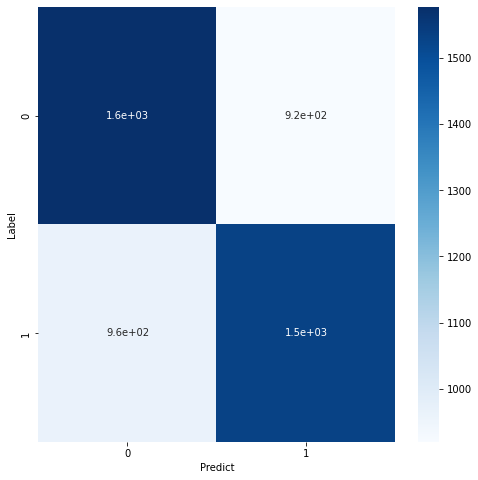

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=val_ds.df["is_laugh"].values,
                        y_pred=np.argmax(val_preds, axis=-1),
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [ ]:
preds = trainer.predict(test_ds).predictions

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


In [ ]:
submission_df["is_laugh"] = softmax(preds, axis=-1)[:, 1]

In [ ]:
submission_df["is_laugh"] = submission_df["is_laugh"].astype(float)

In [ ]:
##OUTPUT = "/content/drive/MyDrive/nishika/sub" # ディレクトリを指定してください
submission_df.to_csv(os.path.join('sub.csv'), index=False)